In [19]:
!pip install opencv-python
import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas
from collections import Counter

In [35]:
DATA_DIR = 'C:/Users/user/CVPR/animals/animals'
LABELS = []
for category in os.listdir(DATA_DIR):
    LABELS.append(category)
print(LABELS)

['cats', 'dogs', 'panda']


In [36]:
IMAGES = []
IMAGE_SIZE = 32
for category in LABELS:
    folder_path = os.path.join(DATA_DIR, category)
    class_index = LABELS.index(category)
    for image_file in tqdm(os.listdir(folder_path)):
        image_array = cv2.imread(os.path.join(folder_path, image_file))
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
        image_array = cv2.resize(image_array, (IMAGE_SIZE, IMAGE_SIZE))
        IMAGES.append([image_array, class_index])
print(len(IMAGES))

100%|██████████| 1000/1000 [00:03<00:00, 284.48it/s]

3000


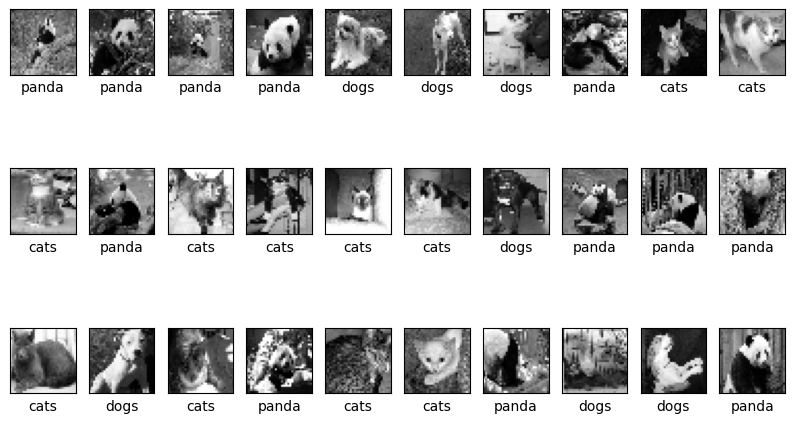

In [37]:
random.shuffle(IMAGES)
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5, 10, i+1)
    img = IMAGES[i][0]
    plt.imshow(img, cmap="gray")
    plt.xlabel(LABELS[IMAGES[i][1]])
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [38]:
fold_0 = IMAGES[0:600]
fold_1 = IMAGES[600:1200]
fold_2 = IMAGES[1200:1800]
fold_3 = IMAGES[1800:2400]
fold_4 = IMAGES[2400:3000]


In [39]:

def manhattan_distance(image1, image2):
    return np.sum(np.abs(image1 - image2))

def euclidean_distance(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))

In [40]:
def get_manhattan_distance(item):
    return item[2]["l1"]

def get_euclidean_distance(item):
    return item[2]["l2"]

In [42]:
top_n = 20

def compute_distances(train_set, validation_set):
    manhattan_results = []
    euclidean_results = []

    for valid_sample in tqdm(validation_set):
        distance_list = []

        for train_sample in train_set:  # Fixed indentation here
            manhattan_dist = manhattan_distance(valid_sample[0], train_sample[0])
            euclidean_dist = euclidean_distance(valid_sample[0], train_sample[0])
            distance_list.append([valid_sample[1], train_sample[1], {"l1": manhattan_dist, "l2": euclidean_dist}])

        distance_list.sort(key=get_manhattan_distance)
        manhattan_results.append(distance_list[:top_n])
        distance_list.sort(key=get_euclidean_distance)
        euclidean_results.append(distance_list[:top_n])

    return [manhattan_results, euclidean_results]


In [43]:
max_k = 20

def compute_accuracy(distance_results, distance_metric):
    accuracy_scores = []

    for k in range(1, max_k + 1):
        correct_preds = 0
        for valid_sample in distance_results:
            nearest_neighbors = valid_sample[:k]
            same_class_neighbors = [nn for nn in nearest_neighbors if nn[0] == nn[1]]
            num_same_class = len(same_class_neighbors)

            if k % 2 != 0:
                if ((k - 1) / 2) < num_same_class:
                    correct_preds += 1

            else:
                different_class_neighbors = [nn for nn in nearest_neighbors if nn[0] != nn[1]]
                if num_same_class > len(different_class_neighbors):
                    correct_preds += 1
                elif num_same_class == len(different_class_neighbors):  # in case of a tie
                    same_class_total_dist = sum([nn[2][distance_metric] for nn in same_class_neighbors])
                    different_class_total_dist = sum([nn[2][distance_metric] for nn in different_class_neighbors])
                    if same_class_total_dist < different_class_total_dist:
                        correct_preds += 1

        accuracy_scores.append(correct_preds / len(distance_results))

    return accuracy_scores

In [44]:
distances_per_fold = []
import math

for fold_index in range(5):
    if fold_index == 0:
        train_set = fold_1 + fold_2 + fold_3 + fold_4
        validation_set = fold_0
    elif fold_index == 1:
        train_set = fold_0 + fold_2 + fold_3 + fold_4
        validation_set = fold_1
    elif fold_index == 2:
        train_set = fold_0 + fold_1 + fold_3 + fold_4
        validation_set = fold_2
    elif fold_index == 3:
        train_set = fold_0 + fold_1 + fold_2 + fold_4
        validation_set = fold_3
    elif fold_index == 4:
        train_set = fold_0 + fold_1 + fold_2 + fold_3
        validation_set = fold_4

    distances_per_fold.append(compute_distances(train_set, validation_set))

100%|██████████| 600/600 [00:25<00:00, 23.54it/s]


In [46]:
accuracy_list = []

for results in distances_per_fold:
    l1_accuracy = compute_accuracy(results[0], "l1")
    l2_accuracy = compute_accuracy(results[1], "l2")
    accuracy_list.append([l1_accuracy, l2_accuracy])

len(accuracy_list)

5

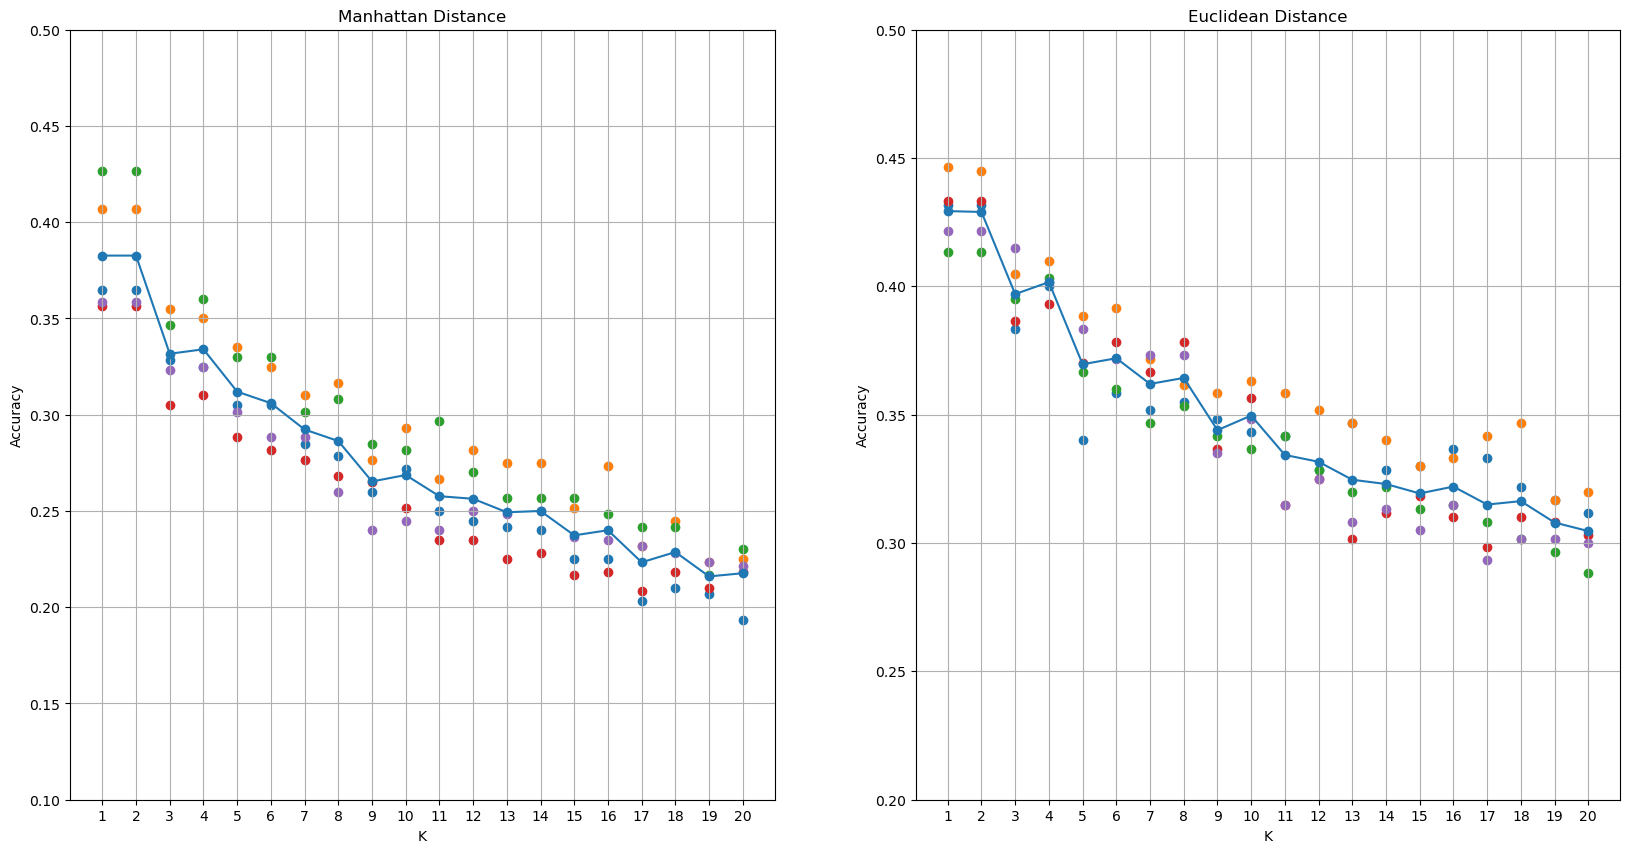

In [47]:
# L1 distance accuracy plot
x_values = list(range(1, max_k + 1))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)

for fold in accuracy_list:
    y_values = fold[0]
    plt.scatter(x_values, y_values)

arr = []
for i in range(max_k):
    arr.append([fold[0][i] for fold in accuracy_list])

average_trend = [np.mean(a) for a in arr]

plt.errorbar(x_values, average_trend, fmt='-o')
plt.title('Manhattan Distance')
plt.xticks(x_values)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.1, 0.5)

# L2 distance accuracy plot
x_values = list(range(1, max_k + 1))

plt.subplot(1, 2, 2)
for fold in accuracy_list:
    y_values = fold[1]
    plt.scatter(x_values, y_values)

arr = []
for i in range(max_k):
    arr.append([fold[1][i] for fold in accuracy_list])

average_trend = [np.mean(a) for a in arr]

plt.errorbar(x_values, average_trend, fmt='-o')
plt.title('Euclidean Distance')
plt.xticks(x_values)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.2, 0.5)
plt.show()


# Discussion:

The graphs show that both the L1 and L2 distance metrics exhibit a general trend of declining mean accuracy as the value of k increases. Initially, the L2 distance provides slightly better accuracy for smaller k values compared to L1. However, as k increases, both metrics converge toward lower accuracy levels, with L1 converging to a slightly lower accuracy than L2. The L2 distance achieves its highest accuracy around 42% when k = 1, while the L1 distance reaches its peak accuracy of approximately 38% at k = 1 and k = 2. Given that the dataset comprises grayscale images, where features likely represent pixel intensities, the choice of distance metric can greatly affect performance. L1 distance's robustness to outliers can be beneficial in situations where noise or artifacts are present in the images. On the other hand, L2 distance, which is more sensitive to the magnitude of differences due to its squared operation, may capture subtle pixel intensity variations that distinguish between classes more effectively.

Overall, both the Manhattan (L1) and Euclidean (L2) distances follow a similar pattern of performance decline as k increases. However, L2 distance occasionally outperforms L1 at certain lower k values, underscoring its potential advantage in specific scenarios within this dataset.

For the L2 distance, the absence of feature scaling could significantly impact performance since it is highly sensitive to feature magnitudes. Applying standardization or normalization to the pixel intensities in grayscale images might enhance accuracy. While alternative distance metrics may perform better in certain contexts, ensuring that features are scaled consistently is essential for models using the L2 distance.

Moreover, for a small grayscale image dataset (around 3,000 images), data augmentation techniques can help increase the dataset size and improve the model's learning ability, leading to better accuracy. Introducing variations such as rotation, scaling, and flipping through data augmentation can help the model generalize more effectively to new, unseen data.

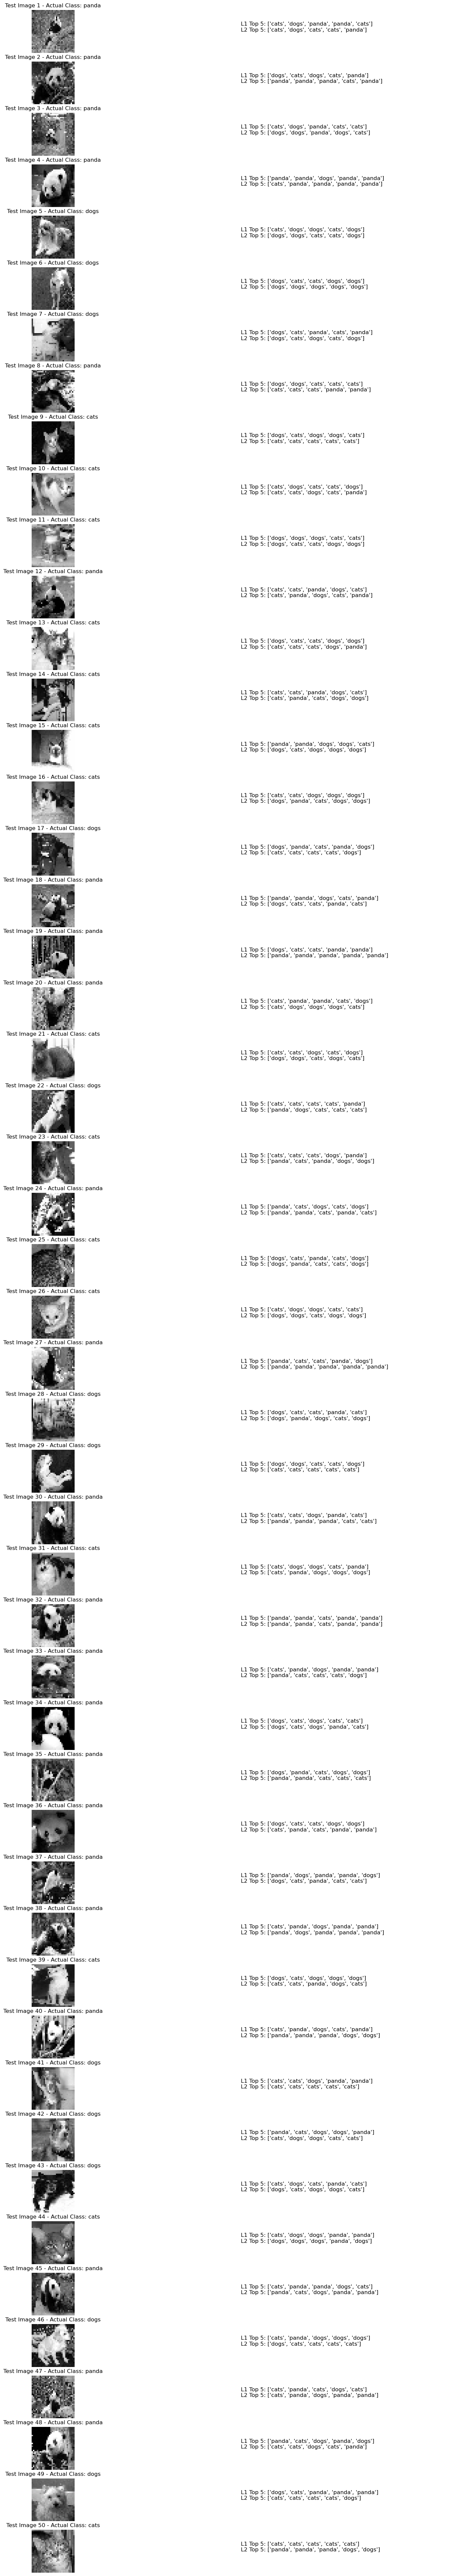

In [49]:
TEST_SET = IMAGES[:50]  
TRAIN_SET = IMAGES[50:]  

top_k = 5
predictions = []

for test_image, test_label in TEST_SET:
    dist_list = []
    
    for train_image, train_label in TRAIN_SET:
        manhattan_dist = manhattan_distance(test_image, train_image)
        euclidean_dist = euclidean_distance(test_image, train_image)
        dist_list.append([train_label, {"l1": manhattan_dist, "l2": euclidean_dist}])
    
    dist_list.sort(key=lambda x: x[1]["l1"])
    top_predictions_l1 = dist_list[:top_k]
    
    dist_list.sort(key=lambda x: x[1]["l2"])
    top_predictions_l2 = dist_list[:top_k]
    
    predictions.append([top_predictions_l1, top_predictions_l2])

plt.figure(figsize=(20, len(TEST_SET) * 2))

for i, (test_image, test_label) in enumerate(TEST_SET):
    plt.subplot(len(TEST_SET), 2, 2*i + 1)
    plt.imshow(test_image, cmap="gray")
    plt.title(f"Test Image {i + 1} - Actual Class: {LABELS[test_label]}")
    plt.axis('off')
    
    plt.subplot(len(TEST_SET), 2, 2*i + 2)
    top_l1_labels = [LABELS[pred[0]] for pred in predictions[i][0]]
    top_l2_labels = [LABELS[pred[0]] for pred in predictions[i][1]]
    plt.text(0.1, 0.5, f"L1 Top 5: {top_l1_labels}\nL2 Top 5: {top_l2_labels}", fontsize=12)
    plt.axis('off')

plt.show()